Modify the KNN scratch code in our lecture such that:
- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class <code>KNN(k=3)</code>.  It should have at least one method, <code>predict(X_train, X_test, y_train)</code>

In [145]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report


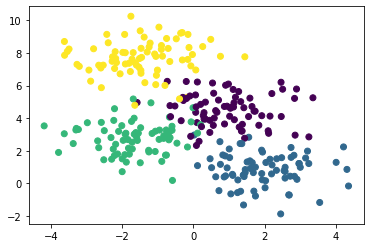

In [146]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

plt.scatter(X[:, 0], X[:, 1], c=y)
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [147]:
class KNN:
    
    def __init__(self, k=3):
        self.k = k
    
    def predict(self,X_train, X_test, y_train):
        n_classes = len(np.unique(y_train))
        neighbors_ix = self.find_neighbors_without_k(X_train, X_test)
        pred = np.zeros(X_test.shape[0])
        prob = np.zeros(X_test.shape[0])
        for ix, y in enumerate(y_train[neighbors_ix]):
            pred[ix],prob[ix] = self.get_most_common(y, n_classes)
        return pred,prob

    def find_distance(self,X_train, X_test):
        #create newaxis simply so that broadcast to all values
        dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        sq_dist = dist ** 2

        summed_dist = sq_dist.sum(axis=2)
        sq_dist = np.sqrt(summed_dist)
        return sq_dist

    def find_neighbors_without_k(self,X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        neighbors_ix = np.argsort(dist)         
        return neighbors_ix

   
    
    def cv(self, X_train, y_train, cv, k):
        foldsize = int(X_train.shape[0]/cv)
        yhat_cv = np.zeros((len(k), cv))
        yhat_cv_prob = np.zeros((len(k), cv)) 
        for k_idx, kneighbors in enumerate(k):
            self.k = kneighbors
            for fold_idx, i in enumerate(range(0, X_train.shape[0], foldsize)):
                X_test_ = X_train[i:i+foldsize]
                y_test_ = y_train[i:i+foldsize]
                X_train_ = np.concatenate((X_train[:i], X_train[i+foldsize:]))
                y_train_ = np.concatenate((y_train[:i], y_train[i+foldsize:]))
                yhat, yhat_prob = self.predict(X_train_, X_test_, y_train_)
                accuracy = np.sum(yhat == y_test_)/len(y_test_)
                yhat_cv[k_idx, fold_idx] = accuracy
                yhat_cv_prob[k_idx, fold_idx] = yhat_prob.mean()
        return yhat_cv, yhat_cv_prob
    
    
    def get_most_common(self,y,n_classes):
        y_near = y[0:self.k]
        count = np.bincount(y_near,minlength=n_classes)
        if count.argmax() ==  count.argsort()[-2] :
            y_near = y[0:self.k+1]
            return np.bincount(y_near).argmax() , count[count.argmax()] / count.sum()  
        return np.bincount(y_near).argmax() , count[count.argmax()] / count.sum()
    
    
    

In [148]:
model = KNN()

#check cv
k = np.arange(2, 11)
cv_score, prob_score = model.cv(X_train, y_train, 10, k)
cv_score = cv_score.mean(axis=1) ## note  CV ใน loop ยังเป็นของแต่ละ i เลยใช้.mean
prob_score = prob_score.mean(axis=1)
for k_idx, kneighbors in enumerate(k):
    print(f"Score with k={kneighbors}: ", cv_score[k_idx], "and prob_score of ", prob_score[k_idx])

#choose model with highest score
model = KNN(k=2)
yhat, yhat_prob = model.predict(X_train, X_test, y_train)

print("=========Accuracy=======")
print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))
print("=========Probability score=======")
print("Probability: ", yhat_prob.mean())



Score with k=2:  0.9333333333333332 and prob_score of  0.9452380952380952
Score with k=3:  0.9333333333333332 and prob_score of  0.946031746031746
Score with k=4:  0.9285714285714285 and prob_score of  0.9404761904761905
Score with k=5:  0.9333333333333332 and prob_score of  0.9352380952380953
Score with k=6:  0.938095238095238 and prob_score of  0.926984126984127
Score with k=7:  0.9333333333333332 and prob_score of  0.9285714285714285
Score with k=8:  0.9333333333333332 and prob_score of  0.9255952380952381
Score with k=9:  0.9333333333333332 and prob_score of  0.9216931216931217
Score with k=10:  0.9238095238095237 and prob_score of  0.9161904761904761
=========Accuracy=======
Accuracy:  0.9333333333333333
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.88      0.88      0.88        25
           1       1.00      1.00      1.00        18
           2       0.92      0.92      0.92        26
           3     